In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os.path import join as p_join

import seaborn as sns


##################################
## GLOBAL SETTINGS ###############
##################################
plt.rcParams["figure.figsize"] = (12,8)

def seed_all(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    print("[ Using Seed : ", seed, " ]")

####################################
#####   SEED ALL EXPERIMENTS   #####
####################################
seed_all()

[ Using Seed :  42  ]


In [3]:
X_path = p_join('..', '..', 'data_2', 'N2=21_L=1.6_input=2', '2nd_exp_Input.txt')
Y_path_down = p_join('..', '..', 'data_2', 'N2=21_L=1.6_input=2', '2nd_exp_Topology_down.txt')
Y_path_up = p_join('..', '..', 'data_2', 'N2=21_L=1.6_input=2', '2nd_exp_Topology_up.txt')
params_path = p_join('..', '..', 'data_2', 'N2=21_L=1.6_input=2', '2nd_exp_Parameters.txt')


X = pd.read_csv(X_path).values
Y_down = pd.read_csv(Y_path_down)
Y_up = pd.read_csv(Y_path_up)
P = pd.read_csv(params_path)

map_clases_back = {0: '0,0', 1: '0,1', 2: '1,0', 3: '1,1'}
Y = []
for i in range(Y_up.shape[0]):
    if Y_up.values[i] == 0 and Y_down.values[i] == 0:
        Y.append(0)
    elif Y_up.values[i] == 0 and Y_down.values[i] == 1:
        Y.append(1)
    elif Y_up.values[i] == 1 and Y_down.values[i] == 0:
        Y.append(2)
    elif Y_up.values[i] == 1 and Y_down.values[i] == 1:
        Y.append(3)
Y = np.array(Y)

In [4]:
###############################
##### IMPORT ML METHODS   #####
###############################
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


#################################
####### GLOBAL CONFIG ###########
#################################
CONFIG = {'scoring': 'accuracy',
          'cv': 5,
          'n_jobs': -1}

In [5]:
def select_n_center_features(data: np.ndarray, n_features: int) -> np.ndarray:
    from copy import deepcopy

    total_components = data.shape[1]
    start = int((total_components - n_features)/2)
    res = deepcopy(data)[:, start: start + n_features]
    print(f'Selected features from indexes:  [{start}, {start + n_features})')
    return res

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from copy import deepcopy

def calc_ml_method(model, config, X, Y):
    res = {}

    scoring = config.get('scoring', 'accuracy')
    cv = config.get('cv', 5)
    n_jobs = config.get('n_jobs', 4)
    
    scores = cross_val_score(model, X, Y, cv=cv, scoring=scoring, n_jobs=n_jobs)
    res[str(scoring)] = scores
        
    return res

def greed_searc_cv(model_class, params, config, X=deepcopy(X), Y=deepcopy(Y)):
    res = {}

    scoring = config.get('scoring', 'accuracy')
    cv = config.get('cv', 5)
    n_jobs = config.get('n_jobs', 4)
    
    model = GridSearchCV(model_class,
                         params,
                         scoring=scoring,
                         cv=cv,
                         n_jobs=n_jobs)
    model.fit(X, Y)
    res[f'best_{str(scoring)}_score'] = model.best_score_
    res['best_params'] = model.best_params_
    res['cv_results'] = model.cv_results_
    
    return res    

### Test `KNeighborsClassifier`

In [7]:
calc_ml_method(KNeighborsClassifier(), CONFIG, X, Y)

{'accuracy': array([1., 1., 1., 1., 1.])}

### Try `KNeighborsClassifier` Grid Search

In [9]:
greed_searc_cv(KNeighborsClassifier(),
               {'n_neighbors': [1,3,5,7], 'weights':['uniform', 'distance']},
               CONFIG,
               X, Y)

{'best_accuracy_score': 1.0,
 'best_params': {'n_neighbors': 1, 'weights': 'uniform'},
 'cv_results': {'mean_fit_time': array([0.00299387, 0.00281587, 0.00284877, 0.00183864, 0.00224924,
         0.00230088, 0.00271811, 0.002282  ]),
  'std_fit_time': array([0.00065853, 0.00150719, 0.00045669, 0.00040798, 0.00037842,
         0.00038618, 0.00080227, 0.00069967]),
  'mean_score_time': array([0.11821737, 0.08208146, 0.1286994 , 0.08850942, 0.11996851,
         0.09154525, 0.13649793, 0.08166766]),
  'std_score_time': array([0.02136094, 0.01296937, 0.01250829, 0.00593477, 0.00705528,
         0.00561202, 0.01006743, 0.01995235]),
  'param_n_neighbors': masked_array(data=[1, 1, 3, 3, 5, 5, 7, 7],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                     'uniform', 'distance', 'uniform', 'distance'],
              

### Try 16 center features

In [10]:
# Select 16 senter featrues
X = select_n_center_features(X, 16)

Selected features from indexes:  [2, 18)


In [11]:
### Log regression
accuracies_log_reg = calc_ml_method(LogisticRegression(), CONFIG, X, Y)
accuracies_log_reg

{'accuracy': array([1., 1., 1., 1., 1.])}

In [12]:
### KNN[5]
accuracies_knn = calc_ml_method(KNeighborsClassifier(n_neighbors=5), CONFIG, X, Y)
accuracies_knn

{'accuracy': array([1., 1., 1., 1., 1.])}

In [13]:
### MLP
accuracies_mlp = calc_ml_method(MLPClassifier(), CONFIG, X, Y)
accuracies_mlp

{'accuracy': array([1., 1., 1., 1., 1.])}

In [14]:
### GaussianNB
accuracies_GNB = calc_ml_method(GaussianNB(), CONFIG, X, Y)
accuracies_GNB

{'accuracy': array([1., 1., 1., 1., 1.])}

In [15]:
### SVC
accuracies_SVC = calc_ml_method(svm.SVC(), CONFIG, X, Y)
accuracies_SVC

{'accuracy': array([1., 1., 1., 1., 1.])}

In [16]:
### Lin Classifier
accuracies_lin_reg = calc_ml_method(SGDClassifier(), CONFIG, X, Y)
accuracies_lin_reg

{'accuracy': array([1., 1., 1., 1., 1.])}

In [17]:
### RF Classifier
accuracies_rf = calc_ml_method(RandomForestClassifier(random_state=42), CONFIG, X, Y)
accuracies_rf

{'accuracy': array([1., 1., 1., 1., 1.])}

### Feature importance on entire dataset

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00167
Feature: 5, Score: 0.00027
Feature: 6, Score: 0.33012
Feature: 7, Score: 0.01675
Feature: 8, Score: 11.23340
Feature: 9, Score: -0.16602
Feature: 10, Score: 1.78998
Feature: 11, Score: 0.99902
Feature: 12, Score: -2.88763
Feature: 13, Score: -0.22972
Feature: 14, Score: -10.87900
Feature: 15, Score: -0.13343
Feature: 16, Score: -0.33109
Feature: 17, Score: -0.00462
Feature: 18, Score: -0.00180
Feature: 19, Score: -0.00003
Feature: 20, Score: -3.85133


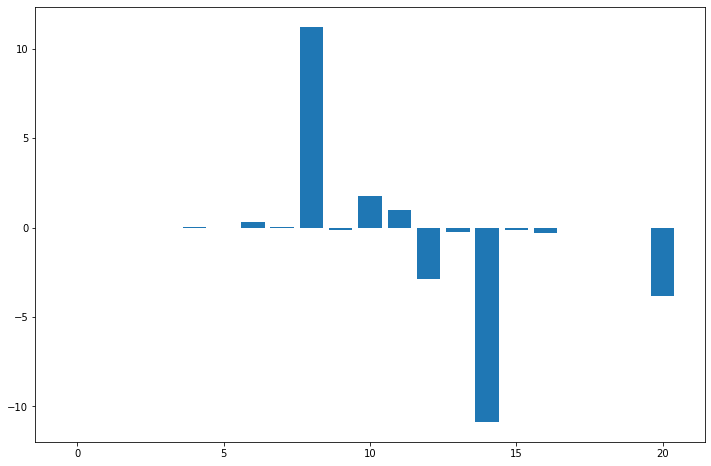

In [22]:
# Train Log Reg on entire dataset to get feature importance
X = pd.read_csv(X_path).values
# X = select_n_center_features(X, 16)

model = LogisticRegression()
model.fit(X, Y)

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00230
Feature: 5, Score: -0.00129
Feature: 6, Score: 0.48328
Feature: 7, Score: -0.10350
Feature: 8, Score: 16.92264
Feature: 9, Score: -0.39868
Feature: 10, Score: 1.22957
Feature: 11, Score: 0.37835
Feature: 12, Score: -2.37861
Feature: 13, Score: -0.37723
Feature: 14, Score: -18.43621
Feature: 15, Score: -0.10117
Feature: 16, Score: -0.52997
Feature: 17, Score: -0.00133
Feature: 18, Score: -0.00258
Feature: 19, Score: -0.00001
Feature: 20, Score: -1.08137


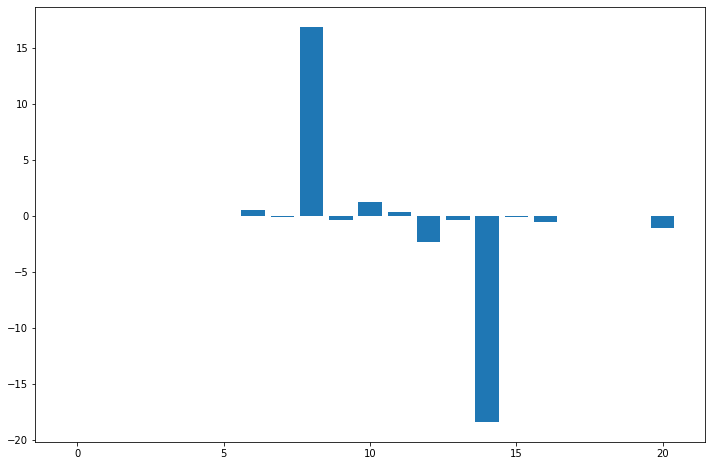

In [23]:
# Train Lin Reg on entire dataset to get feature importance
X = pd.read_csv(X_path).values

model = SGDClassifier()
model.fit(X, Y)

# get importance
importance = model.coef_[0]
# importance.shape
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

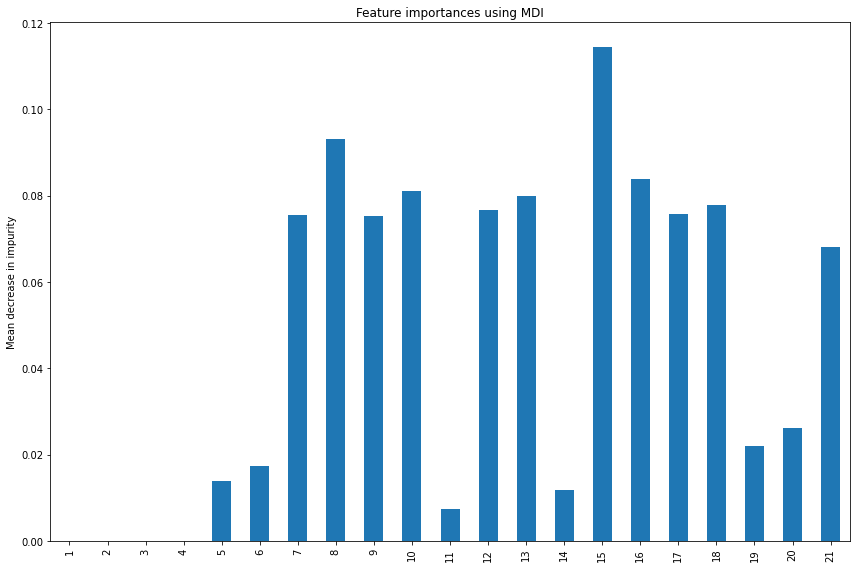

In [24]:
# Train Random Forest on entire dataset to get feature importance
X = pd.read_csv(X_path).values

forest = RandomForestClassifier(random_state=42)
forest.fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

feature_names = [str(i + 1) for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)# yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Try 16 central features

Selected features from indexes:  [2, 18)
Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00178
Feature: 3, Score: 0.00104
Feature: 4, Score: 0.35057
Feature: 5, Score: 0.05600
Feature: 6, Score: 11.83497
Feature: 7, Score: -0.84393
Feature: 8, Score: 2.55434
Feature: 9, Score: 5.18392
Feature: 10, Score: -6.88654
Feature: 11, Score: -0.83085
Feature: 12, Score: -10.57008
Feature: 13, Score: -0.53679
Feature: 14, Score: -0.36995
Feature: 15, Score: -0.01895


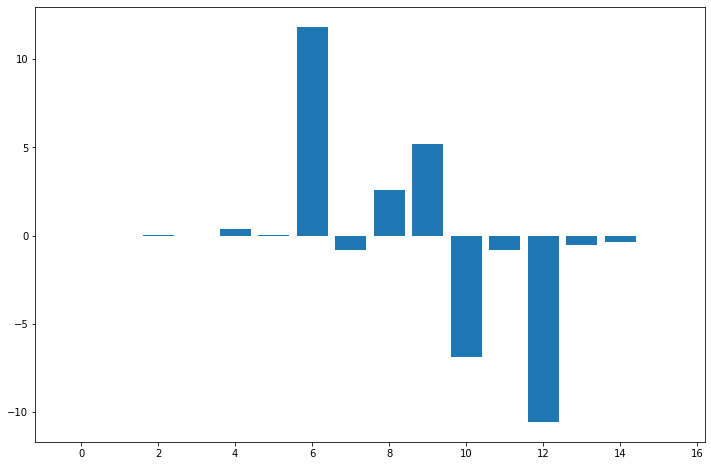

In [26]:
# Train Log Reg on 16 features dataset to get feature importance
X = pd.read_csv(X_path).values
X = select_n_center_features(X, 16)

model = LogisticRegression()
model.fit(X, Y)

# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Selected features from indexes:  [2, 18)


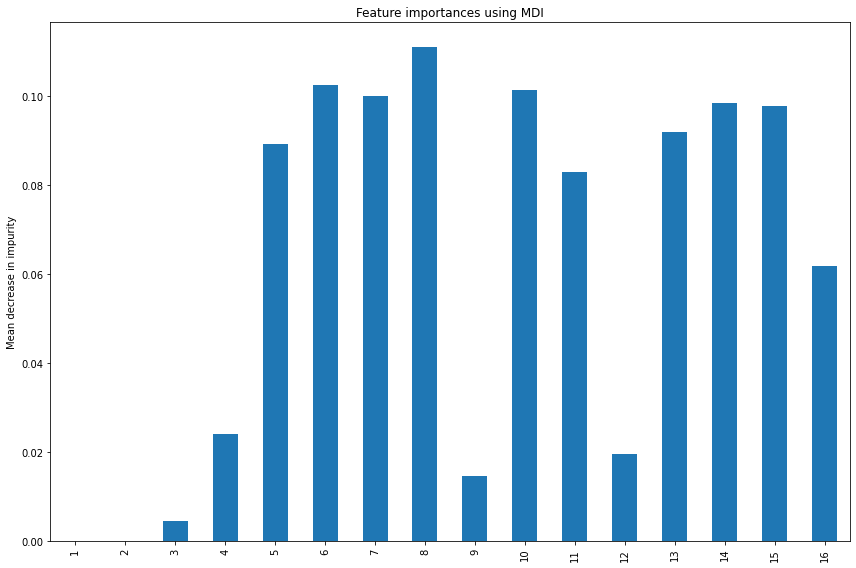

In [27]:
# Train Random Forest on 16 featrues dataset to get feature importance
X = pd.read_csv(X_path).values
X = select_n_center_features(X, 16)

forest = RandomForestClassifier(random_state=42)
forest.fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

feature_names = [str(i + 1) for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)# yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()